Install all required libraries

In [7]:
!pip install keras
!pip install tensorflow  
!pip3 install opencv-python
!pip install pypng
!pip install matplotlib

from google.colab import drive
from google.colab.patches import cv2_imshow
from skimage import data,filters
from PIL import ImageTk, Image

drive.mount('/content/drive')
%cd /content/drive/MyDrive/METER IMAGES/

import cv2
import csv
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
import matplotlib.cm as cm
import numpy as np
import pathlib
import PIL
import os,png,array
import pandas as pd
import time

Mounted at /content/drive
/content/drive/MyDrive/METER IMAGES


Load CNN_SVHN ML Model

In [31]:
from keras.models import load_model
classifier=load_model('cnn_svhn_.model')

Predicting meter value from 169 meter images using CNN_SVHN ML Model

RAJA (148).jpg METER READING=00830None
RAJA (74).jpg METER READING=00630None
RAJA (1).jpg METER READING=000519
RAJA (86).jpg METER READING=006850
RAJA (124).jpg METER READING=002530
RAJA (107).jpg METER READING=000250
RAJA (47).jpg METER READING=00340None
RAJA (38).jpg METER READING=00550None
RAJA (98).jpg METER READING=000719
RAJA (122).jpg METER READING=000252
RAJA (60).jpg METER READING=003220
RAJA (97).jpg METER READING=000730
RAJA (25).jpg METER READING=200516
RAJA (8).jpg METER READING=000523
RAJA (3).jpg METER READING=000513
RAJA (10).jpg METER READING=000525
RAJA (119).jpg METER READING=60NoneNoneNoneNone
RAJA (51).jpg METER READING=000616
RAJA (6).jpg METER READING=007520
RAJA (34).jpg METER READING=005620
RAJA (40).jpg METER READING=005830
RAJA (93).jpg METER READING=006980
RAJA (5).jpg METER READING=000521
RAJA (110).jpg METER READING=000235
RAJA (115).jpg METER READING=00530None
RAJA (168).jpg METER READING=007533
RAJA (72).jpg METER READING=006430
RAJA (81).jpg METER READI

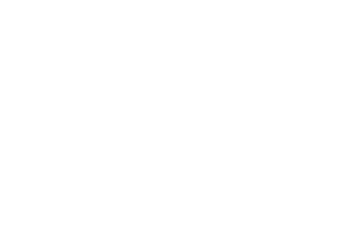

In [32]:
row_list = []
index_counter = 0
resize_counter = 0

directory="/content/drive/My Drive/METER IMAGES/"

for file in os.listdir(directory):
  try:

    if file.endswith(".jpg"): 
        img = cv2.imread(file, 0)

        img = cv2.GaussianBlur(img, (3,3), 0)

        def auto_canny(image, sigma=0.33):

            v = np.median(image)
            lower = int(max(0, (1.0 - sigma) * v))
            upper = int(min(255, (1.0 + sigma) * v))
            edged = cv2.Canny(image, lower, upper, apertureSize=3, L2gradient=True)
            return edged

        edges = auto_canny(img)

        contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        contours_dict = dict()
        for cont in contours:
            x, y, w, h = cv2.boundingRect(cont)
            area = cv2.contourArea(cont)
            if 20 < area and 20 < w and h > 10 :
                contours_dict[(x, y, w, h)] = cont

        contours_filtered = sorted(contours_dict.values(), key=cv2.boundingRect)
        blank_background = np.zeros_like(edges)
        img_contours = cv2.drawContours(blank_background, contours_filtered, -1, (255,255,255), thickness=2)

        def is_overlapping_horizontally(box1, box2):
            x1, _, w1, _ = box1
            x2, _, _, _ = box2
            if x1 > x2:
                return is_overlapping_horizontally(box2, box1)
            return (x2 - x1) < w1

        def merge(box1, box2):
            assert is_overlapping_horizontally(box1, box2)
            x1, y1, w1, h1 = box1
            x2, y2, w2, h2 = box2
            x = min(x1, x2)
            w = max(x1 + w1, x2 + w2) - x
            y = min(y1, y2)
            h = max(y1 + h1, y2 + h2) - y
            return (x, y, w, h)

        def windows(contours):
            boxes = []
            for cont in contours:
                box = cv2.boundingRect(cont)
                if not boxes:
                    boxes.append(box)
                else:
                    if is_overlapping_horizontally(boxes[-1], box):
                        last_box = boxes.pop()
                        merged_box = merge(box, last_box)
                        boxes.append(merged_box)
                    else:
                        boxes.append(box)
            return boxes

        boxes = windows(contours_filtered)
        len_boxes = len(boxes)

        for n in range(len_boxes):
          x, y, w, h = boxes[n]
          plt.axis('off')
          
          if y < 10:
              y = 10
          if x < 10:
              x = 10
              
          roi = img[y-10:y+h+5, x-10:x+w+5]
          roi = cv2.resize(roi,(32, 32),interpolation = cv2.INTER_AREA)
          a = str(n+1)
          cv2.imwrite('basamak'+a+'.png', roi)

        columnNames = list()

        for i in range(1024):
            pixel = 'pixel'
            pixel += str(i)
            columnNames.append(pixel)

        train_data = pd.DataFrame(columns = columnNames)

        for n in range(len_boxes):
            a = str(n+1)
            b='basamak'+a+'.png'
            img = Image.open(b)
            rawData = img.load()
            data = []
            for y in range(32):
                for x in range(32):
                    data.append(rawData[x,y])
            k = 0
            train_data.loc[0] = [data[k] for k in range(1024)]
            train_data = train_data.div(255)
            train_data.to_csv("train_converted"+a+".csv",index = False)


        w ={}
        for n in range(len_boxes):
            a = str(n+1)
            b = "train_converted"+a+".csv"
            x_pred = pd.read_csv(b)
            x_pred = x_pred.iloc[:,:].values.astype('float32')
            x_pred =x_pred.reshape(-1, 32, 32, 1)
            predictions=classifier.predict(x_pred)
            x = predictions[4]
            c = "predictions"+a
            w.update( {c : x.argmax()} )
        
        row = [file,  str(w.get("predictions1")) + 
               str(w.get("predictions2")) +  
               str(w.get("predictions3")) +
               str(w.get("predictions4")) +
               str(w.get("predictions5")) +
               str(w.get("predictions6")) ]

        row_list.append(row)

        print( file + " " + "METER READING=" +
            str(w.get("predictions1")) + 
            str(w.get("predictions2")) +  
            str(w.get("predictions3")) +
            str(w.get("predictions4")) +
            str(w.get("predictions5")) +
            str(w.get("predictions6")) 
            )

        continue
        
    else:
        continue

  except IndexError:
    if IndexError:
      index_counter += 1
      print(file + " " +'List index out of range error')
      print('index count: ', index_counter)
      pass
  
  '''except:
    row = [file, "Resize Error"]
    resize_counter += 1
    print('resize count: ', resize_counter)
    print(file + " " + 'resize error')'''

Create a new file "predicted_meter_reading.csv" for new predicted values

In [33]:
with open('predicted_meter_reading.csv', 'w', newline='') as file:
  writer = csv.writer(file)
  writer.writerows(row_list)
print(len(row_list))

169


Calculating resize counter error and index counter error

In [34]:
print("-------------------------------------")
print("resize counter error:", " ", resize_counter)
print("index counter error:" , " " , index_counter)
print("-------------------------------------")
read = 169 - (int(resize_counter) + int(index_counter))
not_read = int(resize_counter) + int(index_counter)
print("reading: ", read)
print("not reading: ", not_read)
print("-------------------------------------")

-------------------------------------
resize counter error:   0
index counter error:   0
-------------------------------------
reading:  169
not reading:  0
-------------------------------------


Displaying predicted value of the meter

In [35]:
read_value = pd.read_csv("predicted_meter_reading.csv")
read_value.columns = ["imageID", "read_value"]
read_value["imageID"] = read_value["imageID"].str.replace(r'.jpg$', '')
read_value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,imageID,read_value
0,RAJA (74),00630None
1,RAJA (1),000519
2,RAJA (86),006850
3,RAJA (124),002530
4,RAJA (107),000250
...,...,...
163,RAJA (12),007536
164,RAJA (161),000840
165,RAJA (120),000246
166,RAJA (95),007320


Displaying actual value of the meter

In [36]:
real_value = pd.read_excel("ACTUAL_METER_VALUE.xlsx", dtype={'actual_value':np.str})
real_value

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,imageID,actual_value
0,RAJA (1),000494
1,RAJA (2),000513
2,RAJA (3),000521
3,RAJA (4),000521
4,RAJA (5),000522
...,...,...
164,RAJA (165),000496
165,RAJA (166),000496
166,RAJA (167),000503
167,RAJA (168),000507


Merging actual value and predicted read value for comparision

In [37]:
merged = pd.merge(read_value, real_value, on="imageID")
merged

,imageID,read_value,actual_value
0,RAJA (74),00630None,000661
1,RAJA (1),000519,000494
2,RAJA (86),006850,000688
3,RAJA (124),002530,000754
4,RAJA (107),000250,000733
...,...,...,...
162,RAJA (12),007536,000525
163,RAJA (161),000840,000841
164,RAJA (120),000246,000747
165,RAJA (95),007320,000707


Changing "None" to "N" for proper comparision

In [38]:
merged["read_value"] = merged["read_value"].str.replace(r'None', 'N')
merged

,imageID,read_value,actual_value
0,RAJA (74),00630N,000661
1,RAJA (1),000519,000494
2,RAJA (86),006850,000688
3,RAJA (124),002530,000754
4,RAJA (107),000250,000733
...,...,...,...
162,RAJA (12),007536,000525
163,RAJA (161),000840,000841
164,RAJA (120),000246,000747
165,RAJA (95),007320,000707


Checking for exact match

In [39]:
merged['IfMatch'] = np.where(merged['read_value'] == merged['actual_value'], 'True', 'False')
merged[merged['IfMatch'] == 'True']

,imageID,read_value,actual_value,IfMatch
12,RAJA (8),000523,000523,True
33,RAJA (4),000521,000521,True
38,RAJA (30),000558,000558,True


Finding Accuracy

In [40]:
merged["Total"] = merged['read_value'] 

for row in range(167):

  match_counter = 0

  for basamak in range(6):
    if merged['read_value'][row][basamak]== merged['actual_value'][row][basamak]:
      match_counter += 1

  merged['Total'][row] = match_counter

merged["digit_correctness_of_each_meter"] = (merged["Total"]/6)*100
 
print("accuracy:", (sum (merged["Total"])/ (6*167))*100)

merged

accuracy: 52.59481037924152


,imageID,read_value,actual_value,IfMatch,Total,digit_correctness_of_each_meter
0,RAJA (74),00630N,000661,False,2,33.333333
1,RAJA (1),000519,000494,False,3,50.0
2,RAJA (86),006850,000688,False,2,33.333333
3,RAJA (124),002530,000754,False,2,33.333333
4,RAJA (107),000250,000733,False,3,50.0
...,...,...,...,...,...,...
162,RAJA (12),007536,000525,False,3,50.0
163,RAJA (161),000840,000841,False,5,83.333333
164,RAJA (120),000246,000747,False,4,66.666667
165,RAJA (95),007320,000707,False,2,33.333333
